In [ ]:
# 광원, 측정 스펙트럼으로부터 뇌 내 성분 농도 산출
"""
id : 구분자
rho : 측정 거리 (단위: mm)
src : 광원 스펙트럼 (650 nm ~ 990 nm)
dst : 측정 스펙트럼 (650 nm ~ 990 nm)
hhb : 디옥시헤모글로빈 농도
hbo2 : 옥시헤모글로빈 농도
ca : 칼슘 농도
na : 나트륨 농도
"""

In [1]:
import pandas as pd  
import numpy as np                       
import matplotlib.pyplot as plt            
import seaborn as sns                     
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import missingno as msno
from lightgbm import LGBMRegressor

In [2]:
train = pd.read_csv('D:/study/data/train.csv', index_col=0)
test = pd.read_csv('D:/study/data/test.csv', index_col=0)
submission = pd.read_csv('D:/study/data/sample_submission.csv')

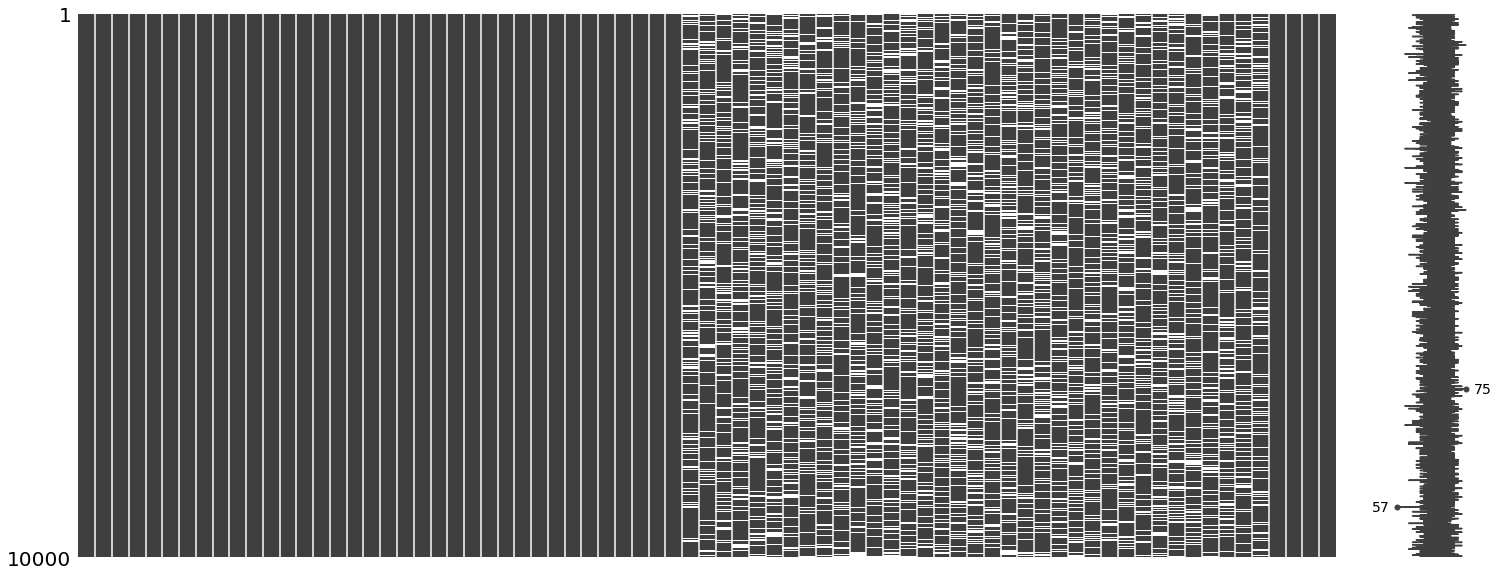

In [3]:
msno.matrix(train)

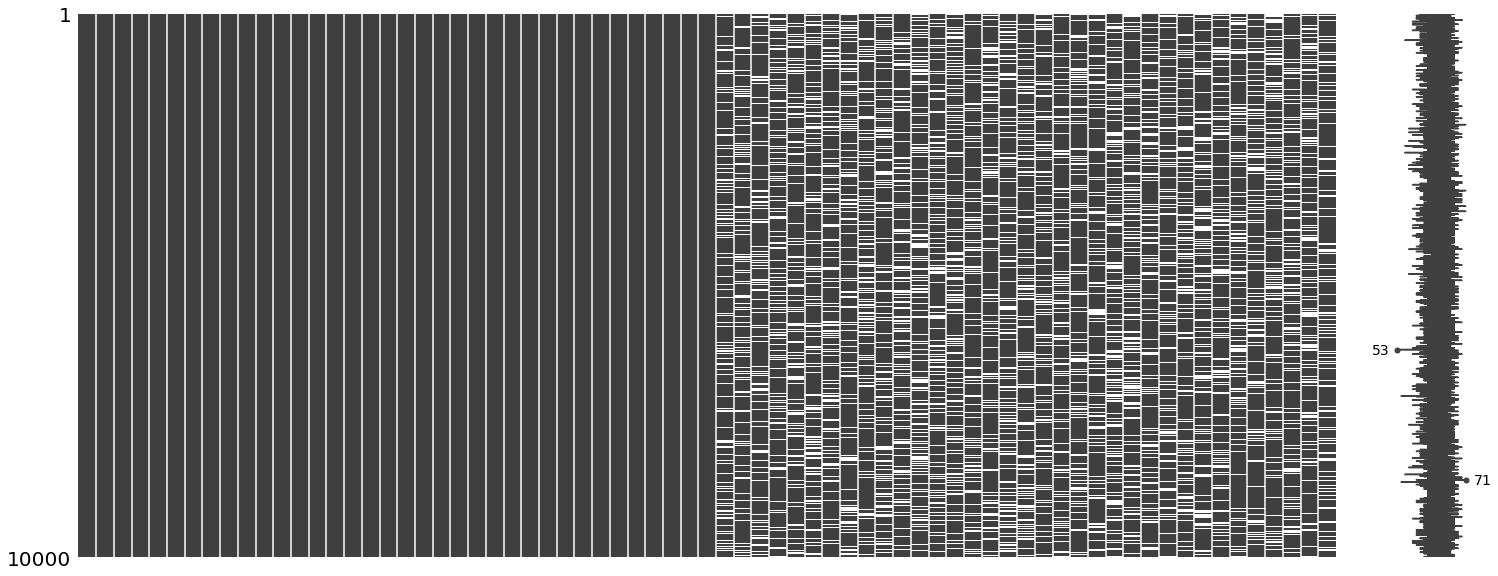

In [4]:
msno.matrix(test)

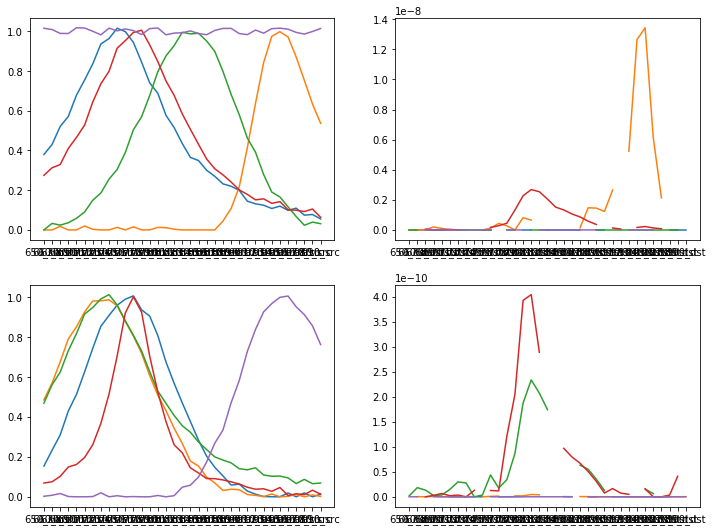

In [6]:
fig = plt.figure(figsize=(12,9))
x1 = fig.add_subplot(2,2,1)
x2 = fig.add_subplot(2,2,2)
x3 = fig.add_subplot(2,2,3)
x4 = fig.add_subplot(2,2,4)
x1.plot(train.filter(regex='_src$',axis=1).head().T) 
x2.plot(train.filter(regex='_dst$',axis=1).head().T) 
x3.plot(test.filter(regex='_src$',axis=1).head().T) 
x4.plot(test.filter(regex='_dst$',axis=1).head().T) 
plt.show()

In [7]:
train_dst = train.filter(regex='_dst$', axis=1).replace(0, np.NaN) # dst 데이터만 따로 뺀다.
test_dst = test.filter(regex='_dst$', axis=1).replace(0, np.NaN) # 보간을 하기위해 결측값을 삭제한다.
train_dst.head(1)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
0,2.447758e-18,1.894578e-18,NaN,6.412913e-18,1.098559e-17,8.907142e-19,NaN,NaN,NaN,NaN,...,NaN,3.527371e-18,NaN,6.455564e-19,NaN,NaN,NaN,1.067504e-18,5.998949e-18,4.378513e-17


In [8]:
test_dst.head(1)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
10000,NaN,NaN,7.028318e-15,NaN,NaN,2.191340e-14,2.204989e-14,NaN,NaN,1.306867e-15,...,NaN,NaN,1.432248e-14,NaN,NaN,6.332117e-15,1.429966e-14,NaN,NaN,7.320236e-14


In [9]:
train_dst = train_dst.interpolate(methods='linear', axis=1)
test_dst = test_dst.interpolate(methods='linear', axis=1)
# 스팩트럼 데이터에서 보간이 되지 않은 값은 0으로 일괄 처리한다.
train_dst.fillna(0, inplace=True) 
test_dst.fillna(0, inplace=True)
test_dst.head(1)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
10000,0.0,0.0,7.028318e-15,1.199001e-14,1.695171e-14,2.191340e-14,2.204989e-14,1.513555e-14,8.221207e-15,1.306867e-15,...,1.808883e-14,1.620565e-14,1.432248e-14,1.165902e-14,8.995570e-15,6.332117e-15,1.429966e-14,3.393389e-14,5.356813e-14,7.320236e-14


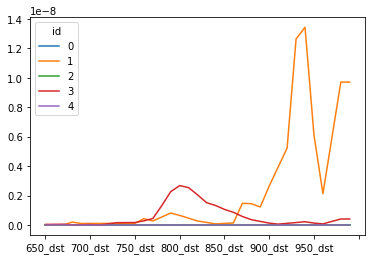

In [10]:
train_dst.head().T.plot()

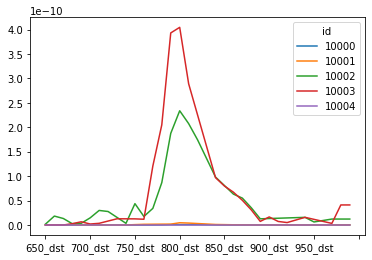

In [11]:
test_dst.head().T.plot()

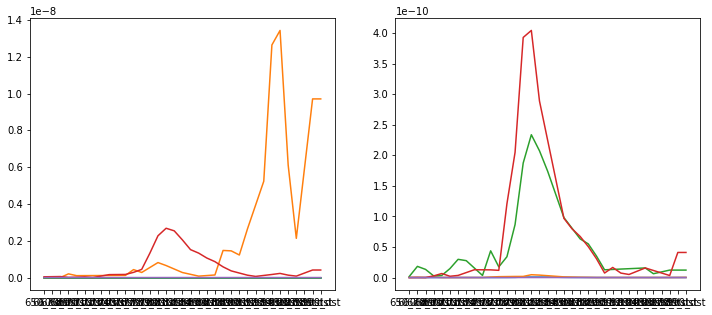

In [14]:
fig = plt.figure(figsize=(12,5))
x1 = fig.add_subplot(1,2,1)
x2 = fig.add_subplot(1,2,2)
x1.plot(train_dst.head().T) 
x2.plot(test_dst.head().T) 
plt.show()

In [15]:
train.update(train_dst) # 보간한 데이터를 기존 데이터프레임에 업데이트 한다.
test.update(test_dst)

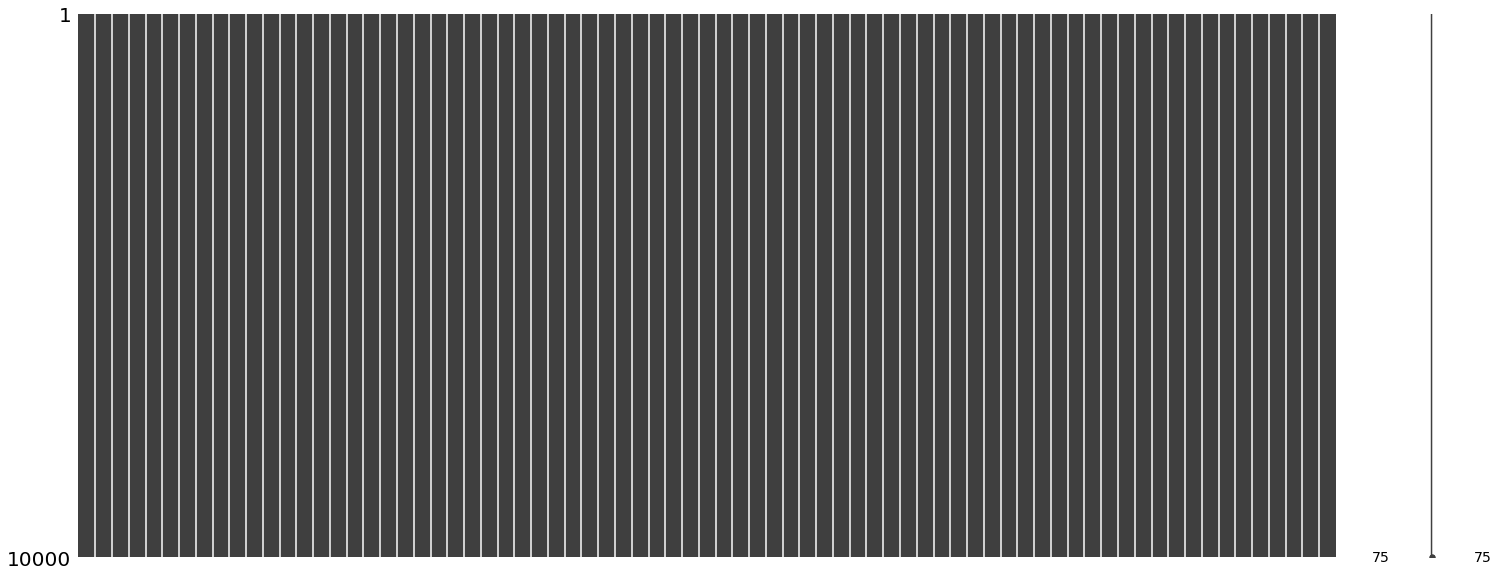

In [16]:
msno.matrix(train)

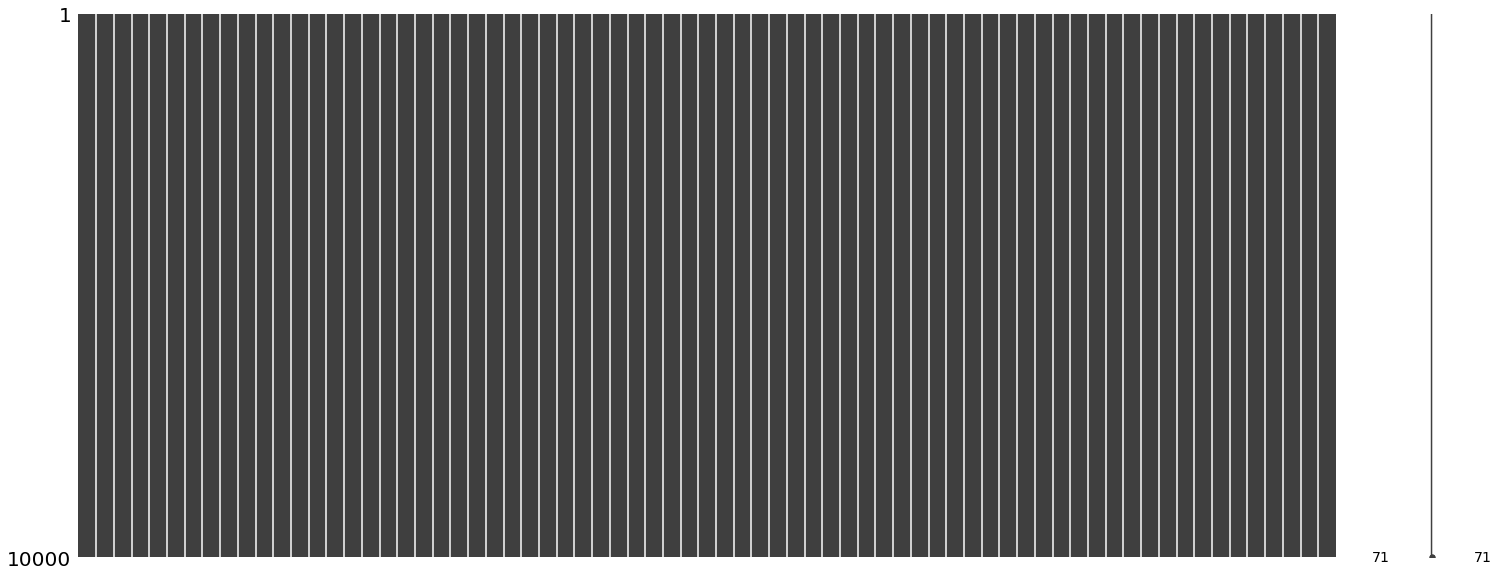

In [17]:
msno.matrix(test)

In [18]:
x_test = test.loc[:, 'rho':'990_dst']
x_train = train.loc[:, 'rho':'990_dst']
y_train = train.loc[:, 'hhb':'na']
x_train.shape, y_train.shape

((10000, 71), (10000, 4))

In [19]:
## Linear Regression
hhb_model = LinearRegression().fit(x_train, y_train['hhb'])
hbo2_model = LinearRegression().fit(x_train, y_train['hbo2'])
ca_model = LinearRegression().fit(x_train, y_train['ca'])
na_model = LinearRegression().fit(x_train, y_train['na'])

hhb_pred = hhb_model.predict(x_train)
hbo2_pred = hbo2_model.predict(x_train)
ca_pred = ca_model.predict(x_train)
na_pred = na_model.predict(x_train)

preds = pd.DataFrame([hhb_pred,hbo2_pred,ca_pred,na_pred])
lr_preds = preds.T
lr_preds

,0,1,2,3
0,7.619358,3.915040,8.848055,3.063103
1,-5.799930,4.095707,0.151422,8.314792
2,7.716111,3.966047,8.870385,3.119769
3,7.404636,4.005167,8.353698,3.204451
4,8.538321,4.129745,9.351122,3.269244
...,...,...,...,...
9995,8.308621,3.957425,9.344774,3.099550
9996,8.031738,4.078459,9.025760,3.020015
9997,8.342546,4.068216,9.317452,3.058450
9998,8.602941,4.141878,9.551088,3.094092


In [20]:
## Random Forest
hhb_model = RandomForestRegressor().fit(x_train, y_train['hhb'])
hbo2_model = RandomForestRegressor().fit(x_train, y_train['hbo2'])
ca_model = RandomForestRegressor().fit(x_train, y_train['ca'])
na_model = RandomForestRegressor().fit(x_train, y_train['na'])

hhb_pred = hhb_model.predict(x_train)
hbo2_pred = hbo2_model.predict(x_train)
ca_pred = ca_model.predict(x_train)
na_pred = na_model.predict(x_train)

preds = pd.DataFrame([hhb_pred,hbo2_pred,ca_pred,na_pred])
rf_preds = preds.T
rf_preds

,0,1,2,3
0,6.0886,4.0198,9.1468,3.6360
1,3.6969,3.2773,7.8991,3.9548
2,9.8491,3.2495,8.4547,4.0377
3,7.0089,3.8560,6.3268,3.8582
4,10.6847,4.3055,10.2380,2.6951
...,...,...,...,...
9995,10.3628,4.0372,10.6411,1.3091
9996,8.2636,4.2842,9.9599,3.0725
9997,8.6827,3.3602,9.1997,2.6541
9998,7.0535,4.0800,10.6606,3.9826


In [21]:
## XGBoost
hhb_model = XGBRegressor().fit(x_train, y_train['hhb'])
hbo2_model = XGBRegressor().fit(x_train, y_train['hbo2'])
ca_model = XGBRegressor().fit(x_train, y_train['ca'])
na_model = XGBRegressor().fit(x_train, y_train['na'])

hhb_pred = hhb_model.predict(x_train)
hbo2_pred = hbo2_model.predict(x_train)
ca_pred = ca_model.predict(x_train)
na_pred = na_model.predict(x_train)

preds = pd.DataFrame([hhb_pred,hbo2_pred,ca_pred,na_pred])
xgb_preds = preds.T
xgb_preds

,0,1,2,3
0,5.831274,4.169127,8.872152,3.231714
1,0.011159,2.858595,7.281300,4.224067
2,10.375117,3.250119,9.007410,2.903337
3,5.483018,3.787890,6.002171,4.092514
4,11.710239,4.326168,10.357036,2.325062
...,...,...,...,...
9995,12.274143,4.332831,11.546816,2.145851
9996,8.540551,4.504870,9.964710,3.971119
9997,9.980747,3.540800,9.062301,2.686752
9998,6.546626,3.925154,11.047863,4.516742


In [22]:
## LGBM
hhb_model = LGBMRegressor().fit(x_train, y_train['hhb'])
hbo2_model = LGBMRegressor().fit(x_train, y_train['hbo2'])
ca_model = LGBMRegressor().fit(x_train, y_train['ca'])
na_model = LGBMRegressor().fit(x_train, y_train['na'])

hhb_pred = hhb_model.predict(x_train)
hbo2_pred = hbo2_model.predict(x_train)
ca_pred = ca_model.predict(x_train)
na_pred = na_model.predict(x_train)

preds = pd.DataFrame([hhb_pred,hbo2_pred,ca_pred,na_pred])
lgbm_preds = preds.T
lgbm_preds

,0,1,2,3
0,5.783372,4.171883,9.164283,3.042999
1,1.560917,2.786370,6.326328,2.751066
2,10.084470,3.413363,9.197837,2.903164
3,6.080824,3.832600,6.483604,3.158170
4,11.348388,4.416038,10.585152,3.338947
...,...,...,...,...
9995,12.443320,4.161039,10.793360,2.831684
9996,8.856045,4.224308,8.968597,3.487718
9997,10.279644,3.653597,8.689736,2.528854
9998,7.190754,3.989278,9.881534,3.909415


In [23]:
## mean_absolute_error
print('lr :',mean_absolute_error(y_train,lr_preds))
print('rf :',mean_absolute_error(y_train,rf_preds))
print('xgb :',mean_absolute_error(y_train,xgb_preds))
print('lgbm :',mean_absolute_error(y_train,lgbm_preds))

lr : 1.7090887935707868
rf : 0.6716646424999986
xgb : 0.5446754963876894
lgbm : 0.9598281379988712


In [29]:
## XGBoost : train_test_split
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.3)

hhb_model2 = XGBRegressor(learning_rate=0.05,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['hhb'])
hbo2_model2 = XGBRegressor(learning_rate=0.05,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['hbo2'])
ca_model2 = XGBRegressor(learning_rate=0.05,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['ca'])
na_model2 = XGBRegressor(learning_rate=0.05,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['na'])

hhb_pred2 = hhb_model2.predict(xx_test)
hbo2_pred2 = hbo2_model2.predict(xx_test)
ca_pred2 = ca_model2.predict(xx_test)
na_pred2 = na_model2.predict(xx_test)

preds2 = pd.DataFrame([hhb_pred2,hbo2_pred2,ca_pred2,na_pred2])
xgb_preds2 = preds2.T

print('xgb')
print('테스트 :',mean_absolute_error(yy_test,xgb_preds2))
print('hhb :',mean_absolute_error(yy_test['hhb'],hhb_pred2))
print('hbo2 :',mean_absolute_error(yy_test['hbo2'],hbo2_pred2))
print('ca :',mean_absolute_error(yy_test['ca'],ca_pred2))
print('na :',mean_absolute_error(yy_test['na'],na_pred2))

xgb
테스트 : 1.2206962861417734
hhb : 0.8872961211828391
hbo2 : 0.6532896127351125
ca : 2.0248907182343796
na : 1.3173086924147606


In [26]:
## LGBM : train_test_split
hhb_model2 = LGBMRegressor(learning_rate=0.05,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['hhb'])
hbo2_model2 = LGBMRegressor(learning_rate=0.05,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['hbo2'])
ca_model2 = LGBMRegressor(learning_rate=0.05,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['ca'])
na_model2 = LGBMRegressor(learning_rate=0.06,max_depth=7,n_estimators=2500).fit(xx_train, yy_train['na'])

hhb_pred2 = hhb_model2.predict(xx_test)
hbo2_pred2 = hbo2_model2.predict(xx_test)
ca_pred2 = ca_model2.predict(xx_test)
na_pred2 = na_model2.predict(xx_test)

preds2 = pd.DataFrame([hhb_pred2,hbo2_pred2,ca_pred2,na_pred2])
lgbm_preds2 = preds2.T

print('lgbm')
print('테스트 :',mean_absolute_error(yy_test,lgbm_preds2))
print('hhb :',mean_absolute_error(yy_test['hhb'],hhb_pred2))
print('hbo2 :',mean_absolute_error(yy_test['hbo2'],hbo2_pred2))
print('ca :',mean_absolute_error(yy_test['ca'],ca_pred2))
print('na :',mean_absolute_error(yy_test['na'],na_pred2))

lgbm
테스트 : 1.2097051304201005
hhb : 0.8777972005049678
hbo2 : 0.6393853302053643
ca : 2.005993990277255
na : 1.3156440006928065


In [27]:
## KFold
from sklearn.model_selection import KFold, cross_val_score   # K-Fold CV
import lightgbm as lgbm

def train_model(x_data, y_data, k=10):
    models = []   
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
        
        eval_set = [(x_val, y_val)]
        model = LGBMRegressor(learning_rate=0.05,
                              max_depth=7,
                              n_estimators=2500).fit(x_train, y_train,
                                                     eval_set=eval_set,eval_metric='mae',
                                                     verbose=False)
        models.append(model)
    return models

In [28]:
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])

train column :  hhb
train column :  hbo2
train column :  ca
train column :  na


In [30]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(x_test))
    pred = np.mean(preds, axis=0)
    submission[col] = pred
submission

,id,hhb,hbo2,ca,na
0,10000,8.734887,4.696541,9.078195,2.647105
1,10001,6.495995,3.481690,9.729124,3.541531
2,10002,9.744852,4.730608,11.002619,3.305080
3,10003,8.355573,4.328589,8.593956,4.005195
4,10004,5.741347,3.607602,8.654210,3.387170
...,...,...,...,...,...
9995,19995,4.634002,3.918837,11.227213,4.138013
9996,19996,11.894248,2.033732,8.531337,3.380228
9997,19997,7.361905,3.487145,9.217163,3.213409
9998,19998,12.912607,4.574199,9.251761,3.905617


In [ ]:
submission.to_csv('D:/study/Dacon_bio_0610.csv', index=False)